# Complex NetCDF to Zarr Recipe: TerraClimate 

## About the Dataset

From http://www.climatologylab.org/terraclimate.html:

> TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019. We plan to update these data periodically (annually).

## What makes it tricky

This is an advanced example that illustrates the following concepts
- _MultiVariable recipe_: There is one file per year for a dozen different variables.
- _Complex Preprocessing_: We want to apply different preprocessing depending on the variable. This example shows how.
- _Inconsistent size of data in input files_: This means we have to scan each input file and cache its metadata before we can start writing the target.

This recipe requires a new storage target, a `metadata_cache`. In this example, this is just another directory. You could hypothetically use a database or other key/value store for this.

In [1]:
from pangeo_forge.recipe import NetCDFtoZarrMultiVarSequentialRecipe
from pangeo_forge.patterns import VariableSequencePattern
import xarray as xr

## Define Filename Pattern 

To keep this example smaller, we just use two years instead of the whole record.

In [3]:
target_chunks = {"lat": 1024, "lon": 1024, "time": 12}
# only do two years to keep the example small; it's still big!
years = list(range(1958, 1960))
variables = [
    "aet",
    "def",
    "pet",
    "ppt",
    "q",
    "soil",
    "srad",
    "swe",
    "tmax",
    "tmin",
    "vap",
    "ws",
    "vpd",
    "PDSI",
]

pattern = VariableSequencePattern(
    fmt_string="https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_{variable}_{year}.nc",
    keys={'variable': variables, 'year': years}
)
pattern

VariableSequencePattern(fmt_string='https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_{variable}_{year}.nc', keys={'variable': ['aet', 'def', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'ws', 'vpd', 'PDSI'], 'year': [1958, 1959]})

VariableSequencePattern(fmt_string='https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_{variable}_{year}.nc', keys={'variable': ['aet', 'def', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'ws', 'vpd', 'PDSI'], 'year': [1958, 1959]})

## Define Preprocessing Functions

These functions apply masks for each variable to remove invalid data.

In [4]:
rename_vars = {'PDSI': 'pdsi'}

mask_opts = {
    "PDSI": ("lt", 10),
    "aet": ("lt", 32767),
    "def": ("lt", 32767),
    "pet": ("lt", 32767),
    "ppt": ("lt", 32767),
    "ppt_station_influence": None,
    "q": ("lt", 2147483647),
    "soil": ("lt", 32767),
    "srad": ("lt", 32767),
    "swe": ("lt", 10000),
    "tmax": ("lt", 200),
    "tmax_station_influence": None,
    "tmin": ("lt", 200),
    "tmin_station_influence": None,
    "vap": ("lt", 300),
    "vap_station_influence": None,
    "vpd": ("lt", 300),
    "ws": ("lt", 200),
}

def apply_mask(key, da):
    """helper function to mask DataArrays based on a threshold value"""
    if mask_opts.get(key, None):
        op, val = mask_opts[key]
        if op == "lt":
            da = da.where(da < val)
        elif op == "neq":
            da = da.where(da != val)
    return da


def preproc(ds):
    """custom preprocessing function for terraclimate data"""
    
    rename = {}

    station_influence = ds.get("station_influence", None)

    if station_influence is not None:
        ds = ds.drop_vars("station_influence")

    var = list(ds.data_vars)[0]

    if var in rename_vars:
        rename[var] = rename_vars[var]

    if "day" in ds.coords:
        rename["day"] = "time"

    if station_influence is not None:
        ds[f"{var}_station_influence"] = station_influence

    with xr.set_options(keep_attrs=True):
        ds[var] = apply_mask(var, ds[var])

    if rename:
        ds = ds.rename(rename)
                
    return ds


## Define Recipe

We are now ready to define the recipe.
We also specify the desired chunks of the target dataset.

A key property of this recipe is `nitems_per_input=None`, which triggers caching of input metadata.

In [5]:
chunks = {"lat": 1024, "lon": 1024, "time": 12}

recipe = NetCDFtoZarrMultiVarSequentialRecipe(
    input_pattern=pattern,
    sequence_dim="time",  # TODO: raise error if this is not specified
    target_chunks=target_chunks,
    nitems_per_input=None, # don't know how many timesteps in each file
    process_chunk=preproc
)
recipe

NetCDFtoZarrMultiVarSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=None, target=<pangeo_forge.storage.UninitializedTarget object at 0x7fbb09e49340>, input_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7fbb09e49370>, metadata_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7fbb09e49520>, require_cache=True, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=None, process_chunk=<function preproc at 0x7fbb09e530d0>, target_chunks={'lat': 1024, 'lon': 1024, 'time': 12}, input_pattern=VariableSequencePattern(fmt_string='https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_{variable}_{year}.nc', keys={'variable': ['aet', 'def', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'ws', 'vpd', 'PDSI'], 'year': [1958, 1959]}))

## Define Storage Targets

Since our recipe needs to cache input metadata, we need to suply a `metadata_cache` target.

In [6]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

meta_dir = tempfile.TemporaryDirectory()
meta_store = FSSpecTarget(fs_local, meta_dir.name)

recipe.target = target
recipe.input_cache = cache_target
recipe.metadata_cache = meta_store
recipe

NetCDFtoZarrMultiVarSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=None, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fbae8454970>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpkbnbkvox'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fbae8454970>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmp509h8xjw'), metadata_cache=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fbae8454970>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmp_nymgtio'), require_cache=True, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=None, process_chunk=<function preproc at 0x7fbb09e530d0>, target_chunks={'lat': 1024, 'lon': 1024, 'time': 12}, input_pattern=VariableSequencePattern(fmt_string='https://climate.northwestknowledge.net/TERRACLIMAT

## Execute with Prefect

This produces A LOT of output because we turn on logging.

In [ ]:
# logging will display some interesting information about our recipe during execution
import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger("pangeo_forge.recipe")
logger.setLevel(logging.INFO)

In [7]:
from pangeo_forge.executors import PrefectPipelineExecutor
pipelines = recipe.to_pipelines()
executor = PrefectPipelineExecutor()
plan = executor.pipelines_to_plan(pipelines)
executor.execute_plan(plan)

[2021-03-20 21:30:59-0400] INFO - prefect.FlowRunner | Beginning Flow run for 'Rechunker'
2021-03-20 21:30:59 [INFO] prefect.FlowRunner - Beginning Flow run for 'Rechunker'
[2021-03-20 21:30:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Starting task run...
2021-03-20 21:30:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper': Starting task run...
[2021-03-20 21:30:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Finished task run for task with final state: 'Mapped'
2021-03-20 21:30:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper': Finished task run for task with final state: 'Mapped'
[2021-03-20 21:30:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Starting task run...
2021-03-20 21:30:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[0]': Starting task run...
2021-03-20 21:30:59 [INFO] pangeo_forge.recipe - Caching input ('aet', 1958)
2021-03-20 21:30:59 [INFO] pangeo_forge.recipe - Opening input 'https://climate.northwe

/opt/miniconda3/envs/pangeo2020/lib/python3.8/contextlib.py:120: UserWarning: Tasks were created but not added to the flow: {<Task: Task>}. This can occur when `Task` classes, including `Parameters`, are instantiated inside a `with flow:` block but not added to the flow either explicitly or as the input to another task. For more information, see https://docs.prefect.io/core/advanced_tutorials/task-guide.html#adding-tasks-to-flows.
  next(self.gen)


2021-03-20 21:31:20 [INFO] pangeo_forge.recipe - Caching metadata for input '('aet', 1958)'
2021-03-20 21:31:20 [INFO] pangeo_forge.recipe - Opening input with Xarray ('aet', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1958.nc'
2021-03-20 21:31:20 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1958.nc' from cache
[2021-03-20 21:31:20-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Finished task run for task with final state: 'Success'
2021-03-20 21:31:20 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[0]': Finished task run for task with final state: 'Success'
[2021-03-20 21:31:20-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Starting task run...
2021-03-20 21:31:20 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[1]': Starting task run...
2021-03-20 21:31:20 [INFO] pangeo_forge.recipe - Caching input ('aet', 1959)
2021-03-20 21:31:20 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'aet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:31:38 [INFO] pangeo_forge.recipe - Caching metadata for input '('aet', 1959)'
2021-03-20 21:31:38 [INFO] pangeo_forge.recipe - Opening input with Xarray ('aet', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1959.nc'
2021-03-20 21:31:38 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1959.nc' from cache
[2021-03-20 21:31:38-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Finished task run for task with final state: 'Success'
2021-03-20 21:31:38 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[1]': Finished task run for task with final state: 'Success'
[2021-03-20 21:31:38-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2]': Starting task run...
2021-03-20 21:31:38 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[2]': Starting task run...
2021-03-20 21:31:38 [INFO] pangeo_forge.recipe - Caching input ('def', 1958)
2021-03-20 21:31:38 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'aet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:31:55 [INFO] pangeo_forge.recipe - Caching metadata for input '('def', 1958)'
2021-03-20 21:31:55 [INFO] pangeo_forge.recipe - Opening input with Xarray ('def', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.nc'
2021-03-20 21:31:55 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.nc' from cache
[2021-03-20 21:31:55-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2]': Finished task run for task with final state: 'Success'
2021-03-20 21:31:55 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[2]': Finished task run for task with final state: 'Success'
[2021-03-20 21:31:55-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[3]': Starting task run...
2021-03-20 21:31:55 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[3]': Starting task run...
2021-03-20 21:31:55 [INFO] pangeo_forge.recipe - Caching input ('def', 1959)
2021-03-20 21:31:55 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'def' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:32:14 [INFO] pangeo_forge.recipe - Caching metadata for input '('def', 1959)'
2021-03-20 21:32:14 [INFO] pangeo_forge.recipe - Opening input with Xarray ('def', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1959.nc'
2021-03-20 21:32:14 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1959.nc' from cache
[2021-03-20 21:32:14-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[3]': Finished task run for task with final state: 'Success'
2021-03-20 21:32:14 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[3]': Finished task run for task with final state: 'Success'
[2021-03-20 21:32:14-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[4]': Starting task run...
2021-03-20 21:32:14 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[4]': Starting task run...
2021-03-20 21:32:14 [INFO] pangeo_forge.recipe - Caching input ('pet', 1958)
2021-03-20 21:32:14 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'def' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:32:35 [INFO] pangeo_forge.recipe - Caching metadata for input '('pet', 1958)'
2021-03-20 21:32:35 [INFO] pangeo_forge.recipe - Opening input with Xarray ('pet', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.nc'
2021-03-20 21:32:35 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.nc' from cache
[2021-03-20 21:32:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[4]': Finished task run for task with final state: 'Success'
2021-03-20 21:32:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[4]': Finished task run for task with final state: 'Success'
[2021-03-20 21:32:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[5]': Starting task run...
2021-03-20 21:32:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[5]': Starting task run...
2021-03-20 21:32:35 [INFO] pangeo_forge.recipe - Caching input ('pet', 1959)
2021-03-20 21:32:35 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:32:56 [INFO] pangeo_forge.recipe - Caching metadata for input '('pet', 1959)'
2021-03-20 21:32:56 [INFO] pangeo_forge.recipe - Opening input with Xarray ('pet', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1959.nc'
2021-03-20 21:32:56 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1959.nc' from cache
[2021-03-20 21:32:56-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[5]': Finished task run for task with final state: 'Success'
2021-03-20 21:32:56 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[5]': Finished task run for task with final state: 'Success'
[2021-03-20 21:32:56-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[6]': Starting task run...
2021-03-20 21:32:56 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[6]': Starting task run...
2021-03-20 21:32:56 [INFO] pangeo_forge.recipe - Caching input ('ppt', 1958)
2021-03-20 21:32:56 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:33:35 [INFO] pangeo_forge.recipe - Caching metadata for input '('ppt', 1958)'
2021-03-20 21:33:35 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ppt', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.nc'
2021-03-20 21:33:35 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.nc' from cache
[2021-03-20 21:33:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[6]': Finished task run for task with final state: 'Success'
2021-03-20 21:33:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[6]': Finished task run for task with final state: 'Success'
[2021-03-20 21:33:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[7]': Starting task run...
2021-03-20 21:33:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[7]': Starting task run...
2021-03-20 21:33:35 [INFO] pangeo_forge.recipe - Caching input ('ppt', 1959)
2021-03-20 21:33:35 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ppt' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:34:09 [INFO] pangeo_forge.recipe - Caching metadata for input '('ppt', 1959)'
2021-03-20 21:34:09 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ppt', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1959.nc'
2021-03-20 21:34:09 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1959.nc' from cache
[2021-03-20 21:34:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[7]': Finished task run for task with final state: 'Success'
2021-03-20 21:34:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[7]': Finished task run for task with final state: 'Success'
[2021-03-20 21:34:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[8]': Starting task run...
2021-03-20 21:34:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[8]': Starting task run...
2021-03-20 21:34:09 [INFO] pangeo_forge.recipe - Caching input ('q', 1958)
2021-03-20 21:34:09 [INFO] pangeo

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ppt' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:34:23 [INFO] pangeo_forge.recipe - Caching metadata for input '('q', 1958)'
2021-03-20 21:34:23 [INFO] pangeo_forge.recipe - Opening input with Xarray ('q', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc'
2021-03-20 21:34:23 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc' from cache
[2021-03-20 21:34:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[8]': Finished task run for task with final state: 'Success'
2021-03-20 21:34:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[8]': Finished task run for task with final state: 'Success'
[2021-03-20 21:34:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[9]': Starting task run...
2021-03-20 21:34:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[9]': Starting task run...
2021-03-20 21:34:23 [INFO] pangeo_forge.recipe - Caching input ('q', 1959)
2021-03-20 21:34:23 [INFO] pangeo_forge.r

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'q' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:34:35 [INFO] pangeo_forge.recipe - Caching metadata for input '('q', 1959)'
2021-03-20 21:34:35 [INFO] pangeo_forge.recipe - Opening input with Xarray ('q', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1959.nc'
2021-03-20 21:34:35 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1959.nc' from cache
[2021-03-20 21:34:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[9]': Finished task run for task with final state: 'Success'
2021-03-20 21:34:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[9]': Finished task run for task with final state: 'Success'
[2021-03-20 21:34:35-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[10]': Starting task run...
2021-03-20 21:34:35 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[10]': Starting task run...
2021-03-20 21:34:35 [INFO] pangeo_forge.recipe - Caching input ('soil', 1958)
2021-03-20 21:34:35 [INFO] pangeo_fo

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'q' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:35:26 [INFO] pangeo_forge.recipe - Caching metadata for input '('soil', 1958)'
2021-03-20 21:35:26 [INFO] pangeo_forge.recipe - Opening input with Xarray ('soil', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1958.nc'
2021-03-20 21:35:26 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1958.nc' from cache
[2021-03-20 21:35:26-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[10]': Finished task run for task with final state: 'Success'
2021-03-20 21:35:26 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[10]': Finished task run for task with final state: 'Success'
[2021-03-20 21:35:26-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[11]': Starting task run...
2021-03-20 21:35:26 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[11]': Starting task run...
2021-03-20 21:35:26 [INFO] pangeo_forge.recipe - Caching input ('soil', 1959)
2021-03-20 21:35:26 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'soil' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:35:48 [INFO] pangeo_forge.recipe - Caching metadata for input '('soil', 1959)'
2021-03-20 21:35:48 [INFO] pangeo_forge.recipe - Opening input with Xarray ('soil', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1959.nc'
2021-03-20 21:35:48 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1959.nc' from cache
[2021-03-20 21:35:48-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[11]': Finished task run for task with final state: 'Success'
2021-03-20 21:35:48 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[11]': Finished task run for task with final state: 'Success'
[2021-03-20 21:35:48-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[12]': Starting task run...
2021-03-20 21:35:48 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[12]': Starting task run...
2021-03-20 21:35:48 [INFO] pangeo_forge.recipe - Caching input ('srad', 1958)
2021-03-20 21:35:48 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'soil' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:36:09 [INFO] pangeo_forge.recipe - Caching metadata for input '('srad', 1958)'
2021-03-20 21:36:09 [INFO] pangeo_forge.recipe - Opening input with Xarray ('srad', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1958.nc'
2021-03-20 21:36:09 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1958.nc' from cache
[2021-03-20 21:36:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[12]': Finished task run for task with final state: 'Success'
2021-03-20 21:36:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[12]': Finished task run for task with final state: 'Success'
[2021-03-20 21:36:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[13]': Starting task run...
2021-03-20 21:36:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[13]': Starting task run...
2021-03-20 21:36:09 [INFO] pangeo_forge.recipe - Caching input ('srad', 1959)
2021-03-20 21:36:09 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'srad' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:36:28 [INFO] pangeo_forge.recipe - Caching metadata for input '('srad', 1959)'
2021-03-20 21:36:28 [INFO] pangeo_forge.recipe - Opening input with Xarray ('srad', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1959.nc'
2021-03-20 21:36:28 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1959.nc' from cache
[2021-03-20 21:36:28-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[13]': Finished task run for task with final state: 'Success'
2021-03-20 21:36:28 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[13]': Finished task run for task with final state: 'Success'
[2021-03-20 21:36:28-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[14]': Starting task run...
2021-03-20 21:36:28 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[14]': Starting task run...
2021-03-20 21:36:28 [INFO] pangeo_forge.recipe - Caching input ('swe', 1958)
2021-03-20 21:36:28 [IN

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'srad' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:36:55 [INFO] pangeo_forge.recipe - Caching metadata for input '('swe', 1958)'
2021-03-20 21:36:55 [INFO] pangeo_forge.recipe - Opening input with Xarray ('swe', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1958.nc'
2021-03-20 21:36:55 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1958.nc' from cache
[2021-03-20 21:36:55-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[14]': Finished task run for task with final state: 'Success'
2021-03-20 21:36:55 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[14]': Finished task run for task with final state: 'Success'
[2021-03-20 21:36:55-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[15]': Starting task run...
2021-03-20 21:36:55 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[15]': Starting task run...
2021-03-20 21:36:55 [INFO] pangeo_forge.recipe - Caching input ('swe', 1959)
2021-03-20 21:36:55 [INFO] 

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'swe' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:37:22 [INFO] pangeo_forge.recipe - Caching metadata for input '('swe', 1959)'
2021-03-20 21:37:22 [INFO] pangeo_forge.recipe - Opening input with Xarray ('swe', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1959.nc'
2021-03-20 21:37:22 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1959.nc' from cache
[2021-03-20 21:37:22-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[15]': Finished task run for task with final state: 'Success'
2021-03-20 21:37:22 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[15]': Finished task run for task with final state: 'Success'
[2021-03-20 21:37:22-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[16]': Starting task run...
2021-03-20 21:37:22 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[16]': Starting task run...
2021-03-20 21:37:22 [INFO] pangeo_forge.recipe - Caching input ('tmax', 1958)
2021-03-20 21:37:22 [INFO]

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'swe' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:37:59 [INFO] pangeo_forge.recipe - Caching metadata for input '('tmax', 1958)'
2021-03-20 21:37:59 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmax', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1958.nc'
2021-03-20 21:37:59 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1958.nc' from cache
[2021-03-20 21:38:00-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[16]': Finished task run for task with final state: 'Success'
2021-03-20 21:38:00 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[16]': Finished task run for task with final state: 'Success'
[2021-03-20 21:38:00-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[17]': Starting task run...
2021-03-20 21:38:00 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[17]': Starting task run...
2021-03-20 21:38:00 [INFO] pangeo_forge.recipe - Caching input ('tmax', 1959)
2021-03-20 21:38:00 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmax' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:38:40 [INFO] pangeo_forge.recipe - Caching metadata for input '('tmax', 1959)'
2021-03-20 21:38:40 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmax', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1959.nc'
2021-03-20 21:38:40 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1959.nc' from cache
[2021-03-20 21:38:40-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[17]': Finished task run for task with final state: 'Success'
2021-03-20 21:38:40 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[17]': Finished task run for task with final state: 'Success'
[2021-03-20 21:38:40-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[18]': Starting task run...
2021-03-20 21:38:40 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[18]': Starting task run...
2021-03-20 21:38:40 [INFO] pangeo_forge.recipe - Caching input ('tmin', 1958)
2021-03-20 21:38:40 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmax' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:39:21 [INFO] pangeo_forge.recipe - Caching metadata for input '('tmin', 1958)'
2021-03-20 21:39:21 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmin', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1958.nc'
2021-03-20 21:39:21 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1958.nc' from cache
[2021-03-20 21:39:21-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[18]': Finished task run for task with final state: 'Success'
2021-03-20 21:39:21 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[18]': Finished task run for task with final state: 'Success'
[2021-03-20 21:39:21-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[19]': Starting task run...
2021-03-20 21:39:21 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[19]': Starting task run...
2021-03-20 21:39:21 [INFO] pangeo_forge.recipe - Caching input ('tmin', 1959)
2021-03-20 21:39:21 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmin' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:40:04 [INFO] pangeo_forge.recipe - Caching metadata for input '('tmin', 1959)'
2021-03-20 21:40:04 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmin', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1959.nc'
2021-03-20 21:40:04 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1959.nc' from cache
[2021-03-20 21:40:04-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[19]': Finished task run for task with final state: 'Success'
2021-03-20 21:40:04 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[19]': Finished task run for task with final state: 'Success'
[2021-03-20 21:40:04-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[20]': Starting task run...
2021-03-20 21:40:04 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[20]': Starting task run...
2021-03-20 21:40:04 [INFO] pangeo_forge.recipe - Caching input ('vap', 1958)
2021-03-20 21:40:04 [IN

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmin' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:40:28 [INFO] pangeo_forge.recipe - Caching metadata for input '('vap', 1958)'
2021-03-20 21:40:28 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vap', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1958.nc'
2021-03-20 21:40:28 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1958.nc' from cache
[2021-03-20 21:40:28-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[20]': Finished task run for task with final state: 'Success'
2021-03-20 21:40:28 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[20]': Finished task run for task with final state: 'Success'
[2021-03-20 21:40:28-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[21]': Starting task run...
2021-03-20 21:40:28 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[21]': Starting task run...
2021-03-20 21:40:28 [INFO] pangeo_forge.recipe - Caching input ('vap', 1959)
2021-03-20 21:40:28 [INFO] 

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vap' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:40:54 [INFO] pangeo_forge.recipe - Caching metadata for input '('vap', 1959)'
2021-03-20 21:40:54 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vap', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1959.nc'
2021-03-20 21:40:54 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1959.nc' from cache
[2021-03-20 21:40:54-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[21]': Finished task run for task with final state: 'Success'
2021-03-20 21:40:54 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[21]': Finished task run for task with final state: 'Success'
[2021-03-20 21:40:54-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[22]': Starting task run...
2021-03-20 21:40:54 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[22]': Starting task run...
2021-03-20 21:40:54 [INFO] pangeo_forge.recipe - Caching input ('ws', 1958)
2021-03-20 21:40:54 [INFO] p

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vap' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:41:13 [INFO] pangeo_forge.recipe - Caching metadata for input '('ws', 1958)'
2021-03-20 21:41:13 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ws', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.nc'
2021-03-20 21:41:13 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.nc' from cache
[2021-03-20 21:41:13-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[22]': Finished task run for task with final state: 'Success'
2021-03-20 21:41:13 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[22]': Finished task run for task with final state: 'Success'
[2021-03-20 21:41:13-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[23]': Starting task run...
2021-03-20 21:41:13 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[23]': Starting task run...
2021-03-20 21:41:13 [INFO] pangeo_forge.recipe - Caching input ('ws', 1959)
2021-03-20 21:41:13 [INFO] pange

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ws' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:41:31 [INFO] pangeo_forge.recipe - Caching metadata for input '('ws', 1959)'
2021-03-20 21:41:31 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ws', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1959.nc'
2021-03-20 21:41:31 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1959.nc' from cache
[2021-03-20 21:41:31-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[23]': Finished task run for task with final state: 'Success'
2021-03-20 21:41:31 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[23]': Finished task run for task with final state: 'Success'
[2021-03-20 21:41:31-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[24]': Starting task run...
2021-03-20 21:41:31 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[24]': Starting task run...
2021-03-20 21:41:31 [INFO] pangeo_forge.recipe - Caching input ('vpd', 1958)
2021-03-20 21:41:31 [INFO] pang

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ws' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:41:58 [INFO] pangeo_forge.recipe - Caching metadata for input '('vpd', 1958)'
2021-03-20 21:41:58 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vpd', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1958.nc'
2021-03-20 21:41:58 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1958.nc' from cache
[2021-03-20 21:41:58-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[24]': Finished task run for task with final state: 'Success'
2021-03-20 21:41:58 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[24]': Finished task run for task with final state: 'Success'
[2021-03-20 21:41:58-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[25]': Starting task run...
2021-03-20 21:41:58 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[25]': Starting task run...
2021-03-20 21:41:58 [INFO] pangeo_forge.recipe - Caching input ('vpd', 1959)
2021-03-20 21:41:58 [INFO] 

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vpd' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:42:27 [INFO] pangeo_forge.recipe - Caching metadata for input '('vpd', 1959)'
2021-03-20 21:42:27 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vpd', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1959.nc'
2021-03-20 21:42:27 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1959.nc' from cache
[2021-03-20 21:42:27-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[25]': Finished task run for task with final state: 'Success'
2021-03-20 21:42:27 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[25]': Finished task run for task with final state: 'Success'
[2021-03-20 21:42:27-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[26]': Starting task run...
2021-03-20 21:42:27 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[26]': Starting task run...
2021-03-20 21:42:27 [INFO] pangeo_forge.recipe - Caching input ('PDSI', 1958)
2021-03-20 21:42:27 [INFO]

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vpd' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:42:47 [INFO] pangeo_forge.recipe - Caching metadata for input '('PDSI', 1958)'
2021-03-20 21:42:47 [INFO] pangeo_forge.recipe - Opening input with Xarray ('PDSI', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1958.nc'
2021-03-20 21:42:47 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1958.nc' from cache
[2021-03-20 21:42:47-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[26]': Finished task run for task with final state: 'Success'
2021-03-20 21:42:47 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[26]': Finished task run for task with final state: 'Success'
[2021-03-20 21:42:47-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[27]': Starting task run...
2021-03-20 21:42:47 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[27]': Starting task run...
2021-03-20 21:42:47 [INFO] pangeo_forge.recipe - Caching input ('PDSI', 1959)
2021-03-20 21:42:47 [I

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'PDSI' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:43:14 [INFO] pangeo_forge.recipe - Caching metadata for input '('PDSI', 1959)'
2021-03-20 21:43:14 [INFO] pangeo_forge.recipe - Opening input with Xarray ('PDSI', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1959.nc'
2021-03-20 21:43:14 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1959.nc' from cache
[2021-03-20 21:43:15-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[27]': Finished task run for task with final state: 'Success'
2021-03-20 21:43:15 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[27]': Finished task run for task with final state: 'Success'
[2021-03-20 21:43:15-0400] INFO - prefect.TaskRunner | Task 'SingleTaskWrapper': Starting task run...
2021-03-20 21:43:15 [INFO] prefect.TaskRunner - Task 'SingleTaskWrapper': Starting task run...
2021-03-20 21:43:15 [INFO] pangeo_forge.recipe - Creating a new dataset in target
2021-03-20 21:43:15 [INFO]

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'PDSI' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'aet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:43:23 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('def', 0)'
2021-03-20 21:43:23 [INFO] pangeo_forge.recipe - Opening input with Xarray ('def', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.nc'
2021-03-20 21:43:23 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'def' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:43:32 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('pet', 0)'
2021-03-20 21:43:32 [INFO] pangeo_forge.recipe - Opening input with Xarray ('pet', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.nc'
2021-03-20 21:43:32 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:43:41 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ppt', 0)'
2021-03-20 21:43:41 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ppt', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.nc'
2021-03-20 21:43:41 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ppt' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:43:56 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('q', 0)'
2021-03-20 21:43:56 [INFO] pangeo_forge.recipe - Opening input with Xarray ('q', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc'
2021-03-20 21:43:56 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'q' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:44:12 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('soil', 0)'
2021-03-20 21:44:12 [INFO] pangeo_forge.recipe - Opening input with Xarray ('soil', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1958.nc'
2021-03-20 21:44:12 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'soil' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:44:21 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('srad', 0)'
2021-03-20 21:44:21 [INFO] pangeo_forge.recipe - Opening input with Xarray ('srad', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1958.nc'
2021-03-20 21:44:21 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'srad' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:44:30 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('swe', 0)'
2021-03-20 21:44:30 [INFO] pangeo_forge.recipe - Opening input with Xarray ('swe', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1958.nc'
2021-03-20 21:44:30 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'swe' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:44:47 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmax', 0)'
2021-03-20 21:44:47 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmax', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1958.nc'
2021-03-20 21:44:47 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmax' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:45:02 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmin', 0)'
2021-03-20 21:45:02 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmin', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1958.nc'
2021-03-20 21:45:02 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmin' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:45:16 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vap', 0)'
2021-03-20 21:45:16 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vap', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1958.nc'
2021-03-20 21:45:16 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vap' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:45:31 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ws', 0)'
2021-03-20 21:45:31 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ws', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.nc'
2021-03-20 21:45:31 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ws' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:45:40 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vpd', 0)'
2021-03-20 21:45:40 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vpd', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1958.nc'
2021-03-20 21:45:40 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vpd' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:45:50 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('PDSI', 0)'
2021-03-20 21:45:50 [INFO] pangeo_forge.recipe - Opening input with Xarray ('PDSI', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1958.nc'
2021-03-20 21:45:50 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1958.nc' from cache


/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'PDSI' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2021-03-20 21:45:59-0400] INFO - prefect.TaskRunner | Task 'SingleTaskWrapper': Finished task run for task with final state: 'Success'
2021-03-20 21:45:59 [INFO] prefect.TaskRunner - Task 'SingleTaskWrapper': Finished task run for task with final state: 'Success'
[2021-03-20 21:45:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Starting task run...
2021-03-20 21:45:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper': Starting task run...
[2021-03-20 21:45:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Finished task run for task with final state: 'Mapped'
2021-03-20 21:45:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper': Finished task run for task with final state: 'Mapped'
[2021-03-20 21:45:59-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Starting task run...
2021-03-20 21:45:59 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[0]': Starting task run...
2021-03-20 21:45:59 [INFO] pangeo_forge.recipe - Concatenating inputs fo

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'aet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:07 [INFO] pangeo_forge.recipe - Storing chunk '('aet', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:46:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[0]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Starting task run...
2021-03-20 21:46:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[1]': Starting task run...
2021-03-20 21:46:09 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('aet', 1)'
2021-03-20 21:46:09 [INFO] pangeo_forge.recipe - Opening input with Xarray ('aet', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1959.nc'
2021-03-20 21:46:09 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_aet_1959.nc

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'aet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:16 [INFO] pangeo_forge.recipe - Storing chunk '('aet', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:46:18-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:18 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[1]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:18-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2]': Starting task run...
2021-03-20 21:46:18 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[2]': Starting task run...
2021-03-20 21:46:18 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('def', 0)'
2021-03-20 21:46:18 [INFO] pangeo_forge.recipe - Opening input with Xarray ('def', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.nc'
2021-03-20 21:46:18 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1958.n

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'def' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:26 [INFO] pangeo_forge.recipe - Storing chunk '('def', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:46:27-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:27 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[2]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:27-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[3]': Starting task run...
2021-03-20 21:46:27 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[3]': Starting task run...
2021-03-20 21:46:27 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('def', 1)'
2021-03-20 21:46:27 [INFO] pangeo_forge.recipe - Opening input with Xarray ('def', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1959.nc'
2021-03-20 21:46:27 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_def_1959.nc

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'def' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:35 [INFO] pangeo_forge.recipe - Storing chunk '('def', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:46:36-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[3]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:36 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[3]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:36-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[4]': Starting task run...
2021-03-20 21:46:36 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[4]': Starting task run...
2021-03-20 21:46:36 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('pet', 0)'
2021-03-20 21:46:36 [INFO] pangeo_forge.recipe - Opening input with Xarray ('pet', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.nc'
2021-03-20 21:46:36 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1958.n

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:44 [INFO] pangeo_forge.recipe - Storing chunk '('pet', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:46:45-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[4]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:45 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[4]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:45-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[5]': Starting task run...
2021-03-20 21:46:45 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[5]': Starting task run...
2021-03-20 21:46:45 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('pet', 1)'
2021-03-20 21:46:45 [INFO] pangeo_forge.recipe - Opening input with Xarray ('pet', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1959.nc'
2021-03-20 21:46:45 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_pet_1959.nc

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:46:53 [INFO] pangeo_forge.recipe - Storing chunk '('pet', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:46:54-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[5]': Finished task run for task with final state: 'Success'
2021-03-20 21:46:54 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[5]': Finished task run for task with final state: 'Success'
[2021-03-20 21:46:54-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[6]': Starting task run...
2021-03-20 21:46:54 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[6]': Starting task run...
2021-03-20 21:46:54 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ppt', 0)'
2021-03-20 21:46:54 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ppt', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.nc'
2021-03-20 21:46:54 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1958.n

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ppt' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:47:07 [INFO] pangeo_forge.recipe - Storing chunk '('ppt', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:47:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[6]': Finished task run for task with final state: 'Success'
2021-03-20 21:47:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[6]': Finished task run for task with final state: 'Success'
[2021-03-20 21:47:09-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[7]': Starting task run...
2021-03-20 21:47:09 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[7]': Starting task run...
2021-03-20 21:47:09 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ppt', 1)'
2021-03-20 21:47:09 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ppt', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1959.nc'
2021-03-20 21:47:09 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ppt_1959.nc

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ppt' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:47:21 [INFO] pangeo_forge.recipe - Storing chunk '('ppt', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:47:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[7]': Finished task run for task with final state: 'Success'
2021-03-20 21:47:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[7]': Finished task run for task with final state: 'Success'
[2021-03-20 21:47:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[8]': Starting task run...
2021-03-20 21:47:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[8]': Starting task run...
2021-03-20 21:47:23 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('q', 0)'
2021-03-20 21:47:23 [INFO] pangeo_forge.recipe - Opening input with Xarray ('q', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc'
2021-03-20 21:47:23 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1958.nc' from 

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'q' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:47:38 [INFO] pangeo_forge.recipe - Storing chunk '('q', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:47:40-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[8]': Finished task run for task with final state: 'Success'
2021-03-20 21:47:40 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[8]': Finished task run for task with final state: 'Success'
[2021-03-20 21:47:40-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[9]': Starting task run...
2021-03-20 21:47:40 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[9]': Starting task run...
2021-03-20 21:47:40 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('q', 1)'
2021-03-20 21:47:40 [INFO] pangeo_forge.recipe - Opening input with Xarray ('q', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1959.nc'
2021-03-20 21:47:40 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_q_1959.nc' from cac

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'q' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:47:55 [INFO] pangeo_forge.recipe - Storing chunk '('q', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:47:57-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[9]': Finished task run for task with final state: 'Success'
2021-03-20 21:47:57 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[9]': Finished task run for task with final state: 'Success'
[2021-03-20 21:47:57-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[10]': Starting task run...
2021-03-20 21:47:57 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[10]': Starting task run...
2021-03-20 21:47:57 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('soil', 0)'
2021-03-20 21:47:57 [INFO] pangeo_forge.recipe - Opening input with Xarray ('soil', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1958.nc'
2021-03-20 21:47:57 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_19

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'soil' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:48:05 [INFO] pangeo_forge.recipe - Storing chunk '('soil', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:48:06-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[10]': Finished task run for task with final state: 'Success'
2021-03-20 21:48:06 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[10]': Finished task run for task with final state: 'Success'
[2021-03-20 21:48:06-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[11]': Starting task run...
2021-03-20 21:48:06 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[11]': Starting task run...
2021-03-20 21:48:06 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('soil', 1)'
2021-03-20 21:48:06 [INFO] pangeo_forge.recipe - Opening input with Xarray ('soil', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soil_1959.nc'
2021-03-20 21:48:06 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_soi

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'soil' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:48:14 [INFO] pangeo_forge.recipe - Storing chunk '('soil', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:48:15-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[11]': Finished task run for task with final state: 'Success'
2021-03-20 21:48:15 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[11]': Finished task run for task with final state: 'Success'
[2021-03-20 21:48:16-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[12]': Starting task run...
2021-03-20 21:48:16 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[12]': Starting task run...
2021-03-20 21:48:16 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('srad', 0)'
2021-03-20 21:48:16 [INFO] pangeo_forge.recipe - Opening input with Xarray ('srad', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1958.nc'
2021-03-20 21:48:16 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_sr

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'srad' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:48:24 [INFO] pangeo_forge.recipe - Storing chunk '('srad', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:48:25-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[12]': Finished task run for task with final state: 'Success'
2021-03-20 21:48:25 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[12]': Finished task run for task with final state: 'Success'
[2021-03-20 21:48:25-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[13]': Starting task run...
2021-03-20 21:48:25 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[13]': Starting task run...
2021-03-20 21:48:25 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('srad', 1)'
2021-03-20 21:48:25 [INFO] pangeo_forge.recipe - Opening input with Xarray ('srad', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_srad_1959.nc'
2021-03-20 21:48:25 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_sra

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'srad' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:48:33 [INFO] pangeo_forge.recipe - Storing chunk '('srad', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:48:34-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[13]': Finished task run for task with final state: 'Success'
2021-03-20 21:48:34 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[13]': Finished task run for task with final state: 'Success'
[2021-03-20 21:48:34-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[14]': Starting task run...
2021-03-20 21:48:34 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[14]': Starting task run...
2021-03-20 21:48:34 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('swe', 0)'
2021-03-20 21:48:34 [INFO] pangeo_forge.recipe - Opening input with Xarray ('swe', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1958.nc'
2021-03-20 21:48:34 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'swe' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:48:49 [INFO] pangeo_forge.recipe - Storing chunk '('swe', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:48:51-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[14]': Finished task run for task with final state: 'Success'
2021-03-20 21:48:51 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[14]': Finished task run for task with final state: 'Success'
[2021-03-20 21:48:51-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[15]': Starting task run...
2021-03-20 21:48:51 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[15]': Starting task run...
2021-03-20 21:48:51 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('swe', 1)'
2021-03-20 21:48:51 [INFO] pangeo_forge.recipe - Opening input with Xarray ('swe', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_1959.nc'
2021-03-20 21:48:51 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_swe_195

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'swe' has multiple fill values {-2147483648, 2147483648}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:49:06 [INFO] pangeo_forge.recipe - Storing chunk '('swe', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:49:08-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[15]': Finished task run for task with final state: 'Success'
2021-03-20 21:49:08 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[15]': Finished task run for task with final state: 'Success'
[2021-03-20 21:49:08-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[16]': Starting task run...
2021-03-20 21:49:08 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[16]': Starting task run...
2021-03-20 21:49:08 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmax', 0)'
2021-03-20 21:49:08 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmax', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1958.nc'
2021-03-20 21:49:08 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tma

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmax' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:49:21 [INFO] pangeo_forge.recipe - Storing chunk '('tmax', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:49:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[16]': Finished task run for task with final state: 'Success'
2021-03-20 21:49:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[16]': Finished task run for task with final state: 'Success'
[2021-03-20 21:49:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[17]': Starting task run...
2021-03-20 21:49:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[17]': Starting task run...
2021-03-20 21:49:23 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmax', 1)'
2021-03-20 21:49:23 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmax', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmax_1959.nc'
2021-03-20 21:49:23 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tma

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmax' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:49:36 [INFO] pangeo_forge.recipe - Storing chunk '('tmax', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:49:38-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[17]': Finished task run for task with final state: 'Success'
2021-03-20 21:49:38 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[17]': Finished task run for task with final state: 'Success'
[2021-03-20 21:49:38-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[18]': Starting task run...
2021-03-20 21:49:38 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[18]': Starting task run...
2021-03-20 21:49:38 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmin', 0)'
2021-03-20 21:49:38 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmin', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1958.nc'
2021-03-20 21:49:38 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tm

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmin' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:49:51 [INFO] pangeo_forge.recipe - Storing chunk '('tmin', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:49:53-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[18]': Finished task run for task with final state: 'Success'
2021-03-20 21:49:53 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[18]': Finished task run for task with final state: 'Success'
[2021-03-20 21:49:53-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[19]': Starting task run...
2021-03-20 21:49:53 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[19]': Starting task run...
2021-03-20 21:49:53 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('tmin', 1)'
2021-03-20 21:49:53 [INFO] pangeo_forge.recipe - Opening input with Xarray ('tmin', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmin_1959.nc'
2021-03-20 21:49:53 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_tmi

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'tmin' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:50:06 [INFO] pangeo_forge.recipe - Storing chunk '('tmin', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:50:08-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[19]': Finished task run for task with final state: 'Success'
2021-03-20 21:50:08 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[19]': Finished task run for task with final state: 'Success'
[2021-03-20 21:50:08-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[20]': Starting task run...
2021-03-20 21:50:08 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[20]': Starting task run...
2021-03-20 21:50:08 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vap', 0)'
2021-03-20 21:50:08 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vap', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1958.nc'
2021-03-20 21:50:08 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vap' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:50:20 [INFO] pangeo_forge.recipe - Storing chunk '('vap', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:50:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[20]': Finished task run for task with final state: 'Success'
2021-03-20 21:50:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[20]': Finished task run for task with final state: 'Success'
[2021-03-20 21:50:23-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[21]': Starting task run...
2021-03-20 21:50:23 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[21]': Starting task run...
2021-03-20 21:50:23 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vap', 1)'
2021-03-20 21:50:23 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vap', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_1959.nc'
2021-03-20 21:50:23 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vap_195

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vap' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'station_influence' has multiple fill values {-8, 248}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:50:35 [INFO] pangeo_forge.recipe - Storing chunk '('vap', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:50:37-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[21]': Finished task run for task with final state: 'Success'
2021-03-20 21:50:37 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[21]': Finished task run for task with final state: 'Success'
[2021-03-20 21:50:37-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[22]': Starting task run...
2021-03-20 21:50:37 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[22]': Starting task run...
2021-03-20 21:50:37 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ws', 0)'
2021-03-20 21:50:37 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ws', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.nc'
2021-03-20 21:50:37 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1958.n

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ws' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:50:45 [INFO] pangeo_forge.recipe - Storing chunk '('ws', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:50:47-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[22]': Finished task run for task with final state: 'Success'
2021-03-20 21:50:47 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[22]': Finished task run for task with final state: 'Success'
[2021-03-20 21:50:47-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[23]': Starting task run...
2021-03-20 21:50:47 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[23]': Starting task run...
2021-03-20 21:50:47 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('ws', 1)'
2021-03-20 21:50:47 [INFO] pangeo_forge.recipe - Opening input with Xarray ('ws', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1959.nc'
2021-03-20 21:50:47 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_ws_1959.nc'

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'ws' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:50:54 [INFO] pangeo_forge.recipe - Storing chunk '('ws', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:50:56-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[23]': Finished task run for task with final state: 'Success'
2021-03-20 21:50:56 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[23]': Finished task run for task with final state: 'Success'
[2021-03-20 21:50:56-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[24]': Starting task run...
2021-03-20 21:50:56 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[24]': Starting task run...
2021-03-20 21:50:56 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vpd', 0)'
2021-03-20 21:50:56 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vpd', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1958.nc'
2021-03-20 21:50:56 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_195

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vpd' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:51:04 [INFO] pangeo_forge.recipe - Storing chunk '('vpd', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:51:05-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[24]': Finished task run for task with final state: 'Success'
2021-03-20 21:51:05 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[24]': Finished task run for task with final state: 'Success'
[2021-03-20 21:51:05-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[25]': Starting task run...
2021-03-20 21:51:05 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[25]': Starting task run...
2021-03-20 21:51:05 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('vpd', 1)'
2021-03-20 21:51:05 [INFO] pangeo_forge.recipe - Opening input with Xarray ('vpd', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_1959.nc'
2021-03-20 21:51:05 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_vpd_195

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'vpd' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:51:13 [INFO] pangeo_forge.recipe - Storing chunk '('vpd', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:51:15-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[25]': Finished task run for task with final state: 'Success'
2021-03-20 21:51:15 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[25]': Finished task run for task with final state: 'Success'
[2021-03-20 21:51:15-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[26]': Starting task run...
2021-03-20 21:51:15 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[26]': Starting task run...
2021-03-20 21:51:15 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('PDSI', 0)'
2021-03-20 21:51:15 [INFO] pangeo_forge.recipe - Opening input with Xarray ('PDSI', 1958): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1958.nc'
2021-03-20 21:51:15 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDS

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'PDSI' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:51:22 [INFO] pangeo_forge.recipe - Storing chunk '('PDSI', 0)' to Zarr region {'time': slice(0, 12, None)}
[2021-03-20 21:51:24-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[26]': Finished task run for task with final state: 'Success'
2021-03-20 21:51:24 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[26]': Finished task run for task with final state: 'Success'
[2021-03-20 21:51:24-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[27]': Starting task run...
2021-03-20 21:51:24 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[27]': Starting task run...
2021-03-20 21:51:24 [INFO] pangeo_forge.recipe - Concatenating inputs for chunk '('PDSI', 1)'
2021-03-20 21:51:24 [INFO] pangeo_forge.recipe - Opening input with Xarray ('PDSI', 1959): 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDSI_1959.nc'
2021-03-20 21:51:24 [INFO] pangeo_forge.recipe - Opening 'https://climate.northwestknowledge.net/TERRACLIMATE-DATA/TerraClimate_PDS

/Users/rpa/Code/xarray/xarray/conventions.py:492: SerializationWarning: variable 'PDSI' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-03-20 21:51:32 [INFO] pangeo_forge.recipe - Storing chunk '('PDSI', 1)' to Zarr region {'time': slice(12, 24, None)}
[2021-03-20 21:51:33-0400] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[27]': Finished task run for task with final state: 'Success'
2021-03-20 21:51:33 [INFO] prefect.TaskRunner - Task 'MappedTaskWrapper[27]': Finished task run for task with final state: 'Success'
[2021-03-20 21:51:33-0400] INFO - prefect.TaskRunner | Task 'SingleTaskWrapper': Starting task run...
2021-03-20 21:51:33 [INFO] prefect.TaskRunner - Task 'SingleTaskWrapper': Starting task run...
2021-03-20 21:51:33 [INFO] pangeo_forge.recipe - Consolidating Zarr metadata
[2021-03-20 21:51:33-0400] INFO - prefect.TaskRunner | Task 'SingleTaskWrapper': Finished task run for task with final state: 'Success'
2021-03-20 21:51:33 [INFO] prefect.TaskRunner - Task 'SingleTaskWrapper': Finished task run for task with final state: 'Success'
[2021-03-20 21:51:33-0400] INFO - prefect.FlowRunner | Flow run SU

<Success: "All reference tasks succeeded.">

## Check and Plot Target

In [8]:
ds_target = xr.open_zarr(target.get_mapper(), consolidated=True)
ds_target

<xarray.Dataset>
Dimensions:                 (crs: 1, lat: 4320, lon: 8640, time: 24)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                    (time) datetime64[ns] 1958-01-01 ... 1959-12-01
Data variables:
    aet                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    def                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pdsi                    (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pet                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt_station_influence   (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    q                       (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    soil                    (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    srad                    (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    swe                     (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmax                    (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmax_station_influence  (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmin                    (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmin_station_influence  (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vap                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vap_station_influence   (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vpd                     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ws                      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
Attributes:
    method:   These layers from TerraClimate were creating using climatically...

As an example calculation, we compute and plot the seasonal climatology of soil moisture.

In [9]:
with xr.set_options(keep_attrs=True):
    soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()
soil_clim

<xarray.DataArray (season: 4, lat: 360, lon: 720)>
dask.array<mean_agg-aggregate, shape=(4, 360, 720), dtype=float32, chunksize=(1, 86, 86), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Soil Moisture at End of Month
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          soil_moisture_content
    standard_name:      soil_moisture_content
    units:              mm

/opt/miniconda3/envs/pangeo2020/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


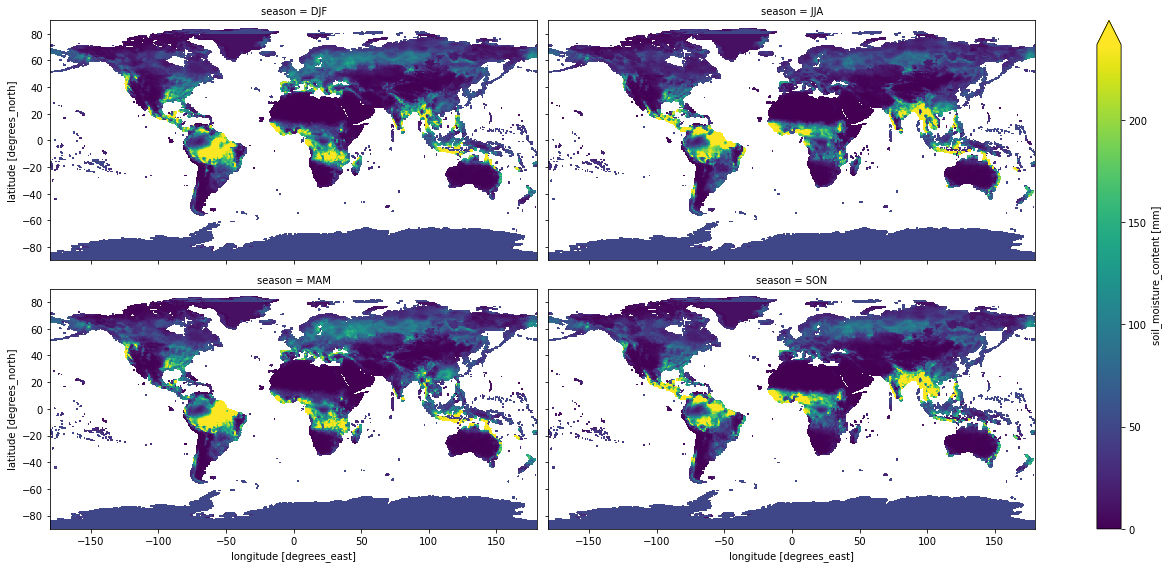

In [11]:
soil_clim.plot(col='season', col_wrap=2, robust=True, figsize=(18, 8))